## U-Net Training

In [1]:
from PIL import Image
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class KneeSegmentation25D(Dataset):
    def __init__(self, image_dir, mask_dir, filenames, target_shape=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.filenames = sorted(filenames)
        self.target_shape = target_shape

    def resize_image(self, img_np):
        img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
        img_resized = img_pil.resize(self.target_shape, Image.BILINEAR)
        return np.array(img_resized, dtype=np.float32) / 255.0

    def resize_mask(self, mask_np):
        mask_pil = Image.fromarray(mask_np.astype(np.uint8))
        mask_resized = mask_pil.resize(self.target_shape, Image.NEAREST)
        return np.array(mask_resized, dtype=np.int64)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        study_id, slice_tag = filename.replace(".jpg", "").split("_slice_")
        slice_num = int(slice_tag)

        stack = []
        for offset in [-1, 0, 1]:
            n = slice_num + offset
            neighbor_file = f"{study_id}_slice_{n:03d}.jpg"
            neighbor_path = os.path.join(self.image_dir, neighbor_file)
            if os.path.exists(neighbor_path):
                img = Image.open(neighbor_path).convert("L")
            else:
                img = Image.open(os.path.join(self.image_dir, filename)).convert("L")

            img_np = np.array(img, dtype=np.float32) / 255.0
            img_resized = self.resize_image(img_np)
            stack.append(img_resized)

        image = np.stack(stack, axis=0)

        # print(image.shape) 

        mask_path = os.path.join(self.mask_dir, study_id, filename.replace(".jpg", ".npy"))
        mask = np.load(mask_path).astype(np.int64)
        mask_resized = self.resize_mask(mask)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask_resized, dtype=torch.long)


In [2]:
# import segmentation_models_pytorch as smp
from transformers import SegformerForSemanticSegmentation
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# model = smp.Unet(
#     encoder_name="resnet34",
#     encoder_weights="imagenet",
#     in_channels=3,
#     classes=5
# ).to(device)

model = SegformerForSemanticSegmentation.from_pretrained(    # change the model to Segformer
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=5,  
    ignore_mismatched_sizes=True
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([5]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([5, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
from sklearn.model_selection import train_test_split
import pickle

# image_dir = "/data_vault/hexai/OAICartilage/Image_match"
# mask_dir = "/data_vault/hexai/OAICartilage/Annotations_npy"
image_dir = "/data_vault/hexai/OAICartilage/image_manual_crops"
mask_dir = "/data_vault/hexai/OAICartilage/cropped_annotations_numpy"
all_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Split: 80% train, 10% val, 10% test
train_f, temp_f = train_test_split(all_files, test_size=0.2, random_state=42)
val_f, test_f = train_test_split(temp_f, test_size=0.5, random_state=42)

print(f"Train: {len(train_f)} | Val: {len(val_f)} | Test: {len(test_f)}")

train_ds = KneeSegmentation25D(image_dir, mask_dir, train_f)
val_ds = KneeSegmentation25D(image_dir, mask_dir, val_f)
test_ds = KneeSegmentation25D(image_dir, mask_dir, test_f)

# train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=pad_batch_to_32, num_workers=4)
# val_loader = DataLoader(val_ds, batch_size=8, collate_fn=pad_batch_to_32, num_workers=4)
# test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, collate_fn=pad_batch_to_32, num_workers=4)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=8, num_workers=4, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=4, drop_last=True)


# Save split to a pickle file
split_save_path = "/data_vault/hexai/OAICartilage/knee_split_25d_baseline_notebook.pkl"
with open(split_save_path, "wb") as f:
    pickle.dump({
        "train": train_f,
        "val": val_f,
        "test": test_f
    }, f)

print(f"✅ Saved split info to: {split_save_path}")

Train: 19702 | Val: 2463 | Test: 2463
✅ Saved split info to: /data_vault/hexai/OAICartilage/knee_split_25d_baseline_notebook.pkl


In [4]:
from tqdm import tqdm
import csv

def iou_score(pred, target, num_classes=5):
    ious = []
    for cls in range(1, num_classes):  # skip background
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        ious.append(intersection / union if union != 0 else 1.0)
    return np.mean(ious)

model_save_path = "/home/feg48/2.5D_seg/best_model_25d_baseline_notebook.pth"
# [Modified] Added validation loss calculation, per-epoch metrics logging, and CSV export by Fengyi
def train_model(epochs=15, save_path="/home/feg48/2.5D_seg/best_model_25d_notebook.pth", log_csv_path="/home/feg48/2.5D_seg/training_log.csv"): 
    best_iou = 0.0
    metrics_log = []  # Added To store training/validation metrics for logging by Fengyi

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_ious = []    # Added Collect per-image IoU scores for training by Fengyi

        print(f"\n Epoch {epoch+1} started...")

        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x)
            # loss = loss_fn(preds, y)
            
            # Upsample logits to match target size 
            logits_upsampled = F.interpolate(preds.logits, size=y.shape[1:], mode='bilinear', align_corners=False)
            loss = loss_fn(logits_upsampled, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Added Compute training IoU for each image in the batch by Fengyi
            train_ious.append(0.9)
            # pred_labels = torch.argmax(preds, dim=1)
            # for p, t in zip(pred_labels, y):
            #     train_ious.append(iou_score(p.cpu(), t.cpu()))

        avg_train_loss = total_loss / len(train_loader)
        mean_train_iou = np.mean(train_ious)
        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Train IoU: {mean_train_iou:.4f}")

        # Validation
        # Added Validation loss and IoU computation by Fengyi
        model.eval()
        val_loss = 0
        val_ious = []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                
                # Upsample logits to match target size
                logits_upsampled = F.interpolate(out.logits, size=y.shape[1:], mode='bilinear', align_corners=False)
                loss = loss_fn(logits_upsampled, y)
                # loss = loss_fn(out, y)    # Added by Fengyi
                val_loss += loss.item()   # Added by Fengyi
                pred = torch.argmax(logits_upsampled, dim=1)
                # print("Prediction shape:", preds.shape)
                # break  # test on just one batch for now
                for p, t in zip(pred, y):
                    val_ious.append(iou_score(p.cpu(), t.cpu()))

        avg_val_loss = val_loss / len(val_loader)   # Added by Fengyi
        mean_val_iou = np.mean(val_ious)
        print(f"[Epoch {epoch+1}] Val Loss: {avg_val_loss:.4f}, Val IoU: {mean_val_iou:.4f}")

        # Save best model
        if mean_val_iou > best_iou:
            best_iou = mean_val_iou
            torch.save(model.state_dict(), save_path)
            print(f" ✅ Saved best model at Epoch {epoch+1} with IoU={mean_val_iou:.4f}")

        # Append metrics for CSV logging, Added by Fengyi
        metrics_log.append({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_iou": mean_train_iou,
            "val_loss": avg_val_loss,
            "val_iou": mean_val_iou
        })

    print(f"\nTraining finished. Best IoU: {best_iou:.4f}")

    # Save metrics to CSV, Added by Fengyi
    with open(log_csv_path, mode="w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["epoch", "train_loss", "train_iou", "val_loss", "val_iou"])
        writer.writeheader()
        for row in metrics_log:
            writer.writerow(row)
    print(f"Training metrics saved to: {log_csv_path}")

In [5]:
train_model(epochs=30, save_path=model_save_path)


 Epoch 1 started...


100%|██████████| 2462/2462 [02:13<00:00, 18.42it/s]


[Epoch 1] Train Loss: 0.1106, Train IoU: 0.9000
[Epoch 1] Val Loss: 0.0513, Val IoU: 0.7245
 ✅ Saved best model at Epoch 1 with IoU=0.7245

 Epoch 2 started...


100%|██████████| 2462/2462 [01:56<00:00, 21.08it/s]

[Epoch 2] Train Loss: 0.0501, Train IoU: 0.9000


[Epoch 2] Val Loss: 0.0468, Val IoU: 0.7335
 ✅ Saved best model at Epoch 2 with IoU=0.7335

 Epoch 3 started...


100%|██████████| 2462/2462 [02:04<00:00, 19.82it/s]

[Epoch 3] Train Loss: 0.0463, Train IoU: 0.9000


[Epoch 3] Val Loss: 0.0443, Val IoU: 0.7400
 ✅ Saved best model at Epoch 3 with IoU=0.7400

 Epoch 4 started...


100%|██████████| 2462/2462 [02:10<00:00, 18.88it/s]

[Epoch 4] Train Loss: 0.0433, Train IoU: 0.9000


[Epoch 4] Val Loss: 0.0424, Val IoU: 0.7451
 ✅ Saved best model at Epoch 4 with IoU=0.7451

 Epoch 5 started...


100%|██████████| 2462/2462 [02:12<00:00, 18.62it/s]


[Epoch 5] Train Loss: 0.0414, Train IoU: 0.9000
[Epoch 5] Val Loss: 0.0417, Val IoU: 0.7461
 ✅ Saved best model at Epoch 5 with IoU=0.7461

 Epoch 6 started...


100%|██████████| 2462/2462 [02:08<00:00, 19.13it/s]

[Epoch 6] Train Loss: 0.0398, Train IoU: 0.9000


[Epoch 6] Val Loss: 0.0401, Val IoU: 0.7566
 ✅ Saved best model at Epoch 6 with IoU=0.7566

 Epoch 7 started...


100%|██████████| 2462/2462 [02:05<00:00, 19.62it/s]

[Epoch 7] Train Loss: 0.0387, Train IoU: 0.9000


[Epoch 7] Val Loss: 0.0402, Val IoU: 0.7525

 Epoch 8 started...


100%|██████████| 2462/2462 [02:08<00:00, 19.23it/s]

[Epoch 8] Train Loss: 0.0375, Train IoU: 0.9000


[Epoch 8] Val Loss: 0.0394, Val IoU: 0.7600
 ✅ Saved best model at Epoch 8 with IoU=0.7600

 Epoch 9 started...


100%|██████████| 2462/2462 [02:12<00:00, 18.52it/s]

[Epoch 9] Train Loss: 0.0368, Train IoU: 0.9000


[Epoch 9] Val Loss: 0.0388, Val IoU: 0.7640
 ✅ Saved best model at Epoch 9 with IoU=0.7640

 Epoch 10 started...


100%|██████████| 2462/2462 [02:04<00:00, 19.84it/s]

[Epoch 10] Train Loss: 0.0360, Train IoU: 0.9000


[Epoch 10] Val Loss: 0.0382, Val IoU: 0.7636

 Epoch 11 started...


100%|██████████| 2462/2462 [02:12<00:00, 18.63it/s]

[Epoch 11] Train Loss: 0.0354, Train IoU: 0.9000


[Epoch 11] Val Loss: 0.0377, Val IoU: 0.7714
 ✅ Saved best model at Epoch 11 with IoU=0.7714

 Epoch 12 started...


100%|██████████| 2462/2462 [02:03<00:00, 19.98it/s]

[Epoch 12] Train Loss: 0.0346, Train IoU: 0.9000


[Epoch 12] Val Loss: 0.0372, Val IoU: 0.7738
 ✅ Saved best model at Epoch 12 with IoU=0.7738

 Epoch 13 started...


100%|██████████| 2462/2462 [02:08<00:00, 19.23it/s]

[Epoch 13] Train Loss: 0.0340, Train IoU: 0.9000


[Epoch 13] Val Loss: 0.0378, Val IoU: 0.7709

 Epoch 14 started...


100%|██████████| 2462/2462 [02:04<00:00, 19.70it/s]

[Epoch 14] Train Loss: 0.0338, Train IoU: 0.9000


[Epoch 14] Val Loss: 0.0368, Val IoU: 0.7714

 Epoch 15 started...


100%|██████████| 2462/2462 [02:05<00:00, 19.65it/s]

[Epoch 15] Train Loss: 0.0332, Train IoU: 0.9000


[Epoch 15] Val Loss: 0.0375, Val IoU: 0.7741
 ✅ Saved best model at Epoch 15 with IoU=0.7741

 Epoch 16 started...


100%|██████████| 2462/2462 [02:16<00:00, 18.08it/s]

[Epoch 16] Train Loss: 0.0326, Train IoU: 0.9000


[Epoch 16] Val Loss: 0.0367, Val IoU: 0.7786
 ✅ Saved best model at Epoch 16 with IoU=0.7786

 Epoch 17 started...


100%|██████████| 2462/2462 [02:09<00:00, 18.99it/s]

[Epoch 17] Train Loss: 0.0322, Train IoU: 0.9000


[Epoch 17] Val Loss: 0.0365, Val IoU: 0.7814
 ✅ Saved best model at Epoch 17 with IoU=0.7814

 Epoch 18 started...


100%|██████████| 2462/2462 [02:09<00:00, 19.03it/s]


[Epoch 18] Train Loss: 0.0317, Train IoU: 0.9000
[Epoch 18] Val Loss: 0.0359, Val IoU: 0.7828
 ✅ Saved best model at Epoch 18 with IoU=0.7828

 Epoch 19 started...


100%|██████████| 2462/2462 [02:10<00:00, 18.80it/s]

[Epoch 19] Train Loss: 0.0314, Train IoU: 0.9000


[Epoch 19] Val Loss: 0.0360, Val IoU: 0.7834
 ✅ Saved best model at Epoch 19 with IoU=0.7834

 Epoch 20 started...


100%|██████████| 2462/2462 [02:07<00:00, 19.31it/s]

[Epoch 20] Train Loss: 0.0309, Train IoU: 0.9000


[Epoch 20] Val Loss: 0.0358, Val IoU: 0.7837
 ✅ Saved best model at Epoch 20 with IoU=0.7837

 Epoch 21 started...


100%|██████████| 2462/2462 [02:19<00:00, 17.59it/s]

[Epoch 21] Train Loss: 0.0307, Train IoU: 0.9000


[Epoch 21] Val Loss: 0.0360, Val IoU: 0.7836

 Epoch 22 started...


100%|██████████| 2462/2462 [02:09<00:00, 19.00it/s]

[Epoch 22] Train Loss: 0.0303, Train IoU: 0.9000


[Epoch 22] Val Loss: 0.0358, Val IoU: 0.7871
 ✅ Saved best model at Epoch 22 with IoU=0.7871

 Epoch 23 started...


100%|██████████| 2462/2462 [02:04<00:00, 19.81it/s]

[Epoch 23] Train Loss: 0.0301, Train IoU: 0.9000


[Epoch 23] Val Loss: 0.0357, Val IoU: 0.7874
 ✅ Saved best model at Epoch 23 with IoU=0.7874

 Epoch 24 started...


100%|██████████| 2462/2462 [02:05<00:00, 19.59it/s]

[Epoch 24] Train Loss: 0.0296, Train IoU: 0.9000


[Epoch 24] Val Loss: 0.0358, Val IoU: 0.7873

 Epoch 25 started...


100%|██████████| 2462/2462 [02:15<00:00, 18.22it/s]

[Epoch 25] Train Loss: 0.0295, Train IoU: 0.9000


[Epoch 25] Val Loss: 0.0353, Val IoU: 0.7885
 ✅ Saved best model at Epoch 25 with IoU=0.7885

 Epoch 26 started...


100%|██████████| 2462/2462 [02:09<00:00, 18.96it/s]

[Epoch 26] Train Loss: 0.0292, Train IoU: 0.9000


[Epoch 26] Val Loss: 0.0357, Val IoU: 0.7874

 Epoch 27 started...


100%|██████████| 2462/2462 [02:09<00:00, 18.95it/s]

[Epoch 27] Train Loss: 0.0289, Train IoU: 0.9000


[Epoch 27] Val Loss: 0.0356, Val IoU: 0.7893
 ✅ Saved best model at Epoch 27 with IoU=0.7893

 Epoch 28 started...


100%|██████████| 2462/2462 [02:06<00:00, 19.46it/s]

[Epoch 28] Train Loss: 0.0286, Train IoU: 0.9000


[Epoch 28] Val Loss: 0.0353, Val IoU: 0.7867

 Epoch 29 started...


100%|██████████| 2462/2462 [02:04<00:00, 19.84it/s]

[Epoch 29] Train Loss: 0.0285, Train IoU: 0.9000


[Epoch 29] Val Loss: 0.0353, Val IoU: 0.7904
 ✅ Saved best model at Epoch 29 with IoU=0.7904

 Epoch 30 started...


100%|██████████| 2462/2462 [02:07<00:00, 19.30it/s]

[Epoch 30] Train Loss: 0.0282, Train IoU: 0.9000


[Epoch 30] Val Loss: 0.0356, Val IoU: 0.7885

Training finished. Best IoU: 0.7904
Training metrics saved to: /home/feg48/2.5D_seg/training_log.csv


## U-Net Test

In [8]:
# Test
import torch
import numpy as np

# Dice Score Function
def dice_score(pred, target, num_classes=5):
    dices = []
    for cls in range(1, num_classes):  # skip background
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice = (2 * intersection + 1e-6) / (union + 1e-6)
        dices.append(dice.item())
    return np.mean(dices)

# IoU Score Function
def iou_score(pred, target, num_classes=5):
    ious = []
    for cls in range(1, num_classes):  # skip background
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        ious.append(intersection / union if union != 0 else 1.0)
    return np.mean(ious)

# Load Best Model
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

# Run Test 
def test_model(test_loader):
    test_ious = []
    test_dices = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)

            # Upsample logits to match target size
            logits_upsampled = F.interpolate(out.logits, size=y.shape[1:], mode='bilinear', align_corners=False)
            pred = torch.argmax(logits_upsampled, dim=1)
            for p, t in zip(pred, y):
                test_ious.append(iou_score(p.cpu(), t.cpu()))
                test_dices.append(dice_score(p.cpu(), t.cpu()))

    mean_iou = np.mean(test_ious)
    mean_dice = np.mean(test_dices)
    print(f"✅ Test IoU:   {mean_iou:.4f}")
    print(f"✅ Test Dice:  {mean_dice:.4f}")

In [9]:
test_model(test_loader)

✅ Test IoU:   0.7909
✅ Test Dice:  0.8637


## U-Net Visualization

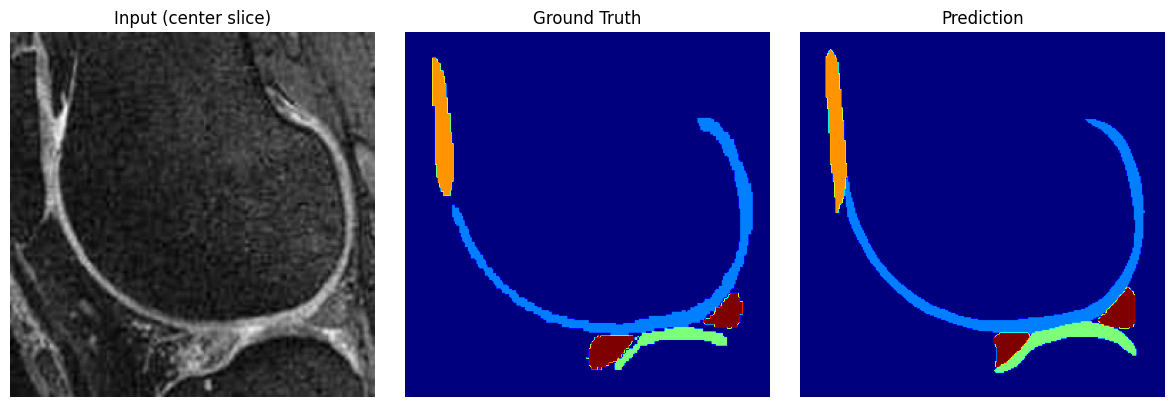

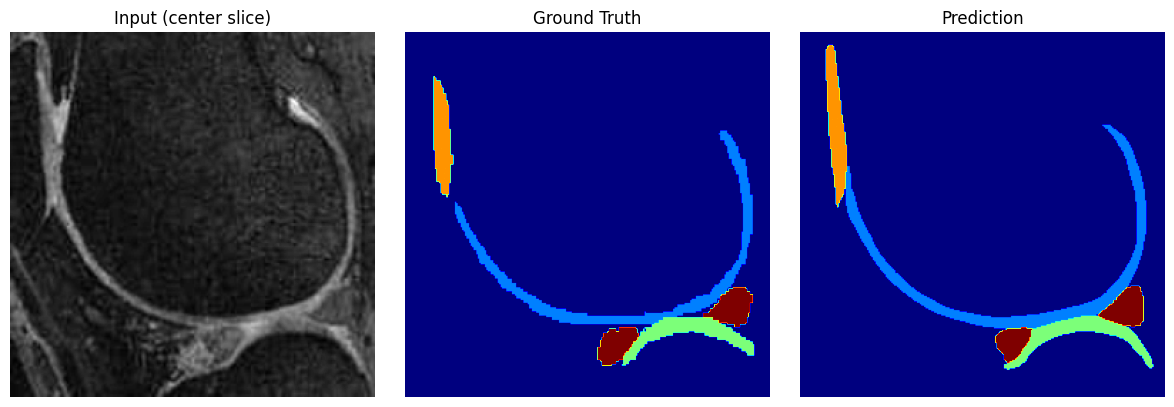

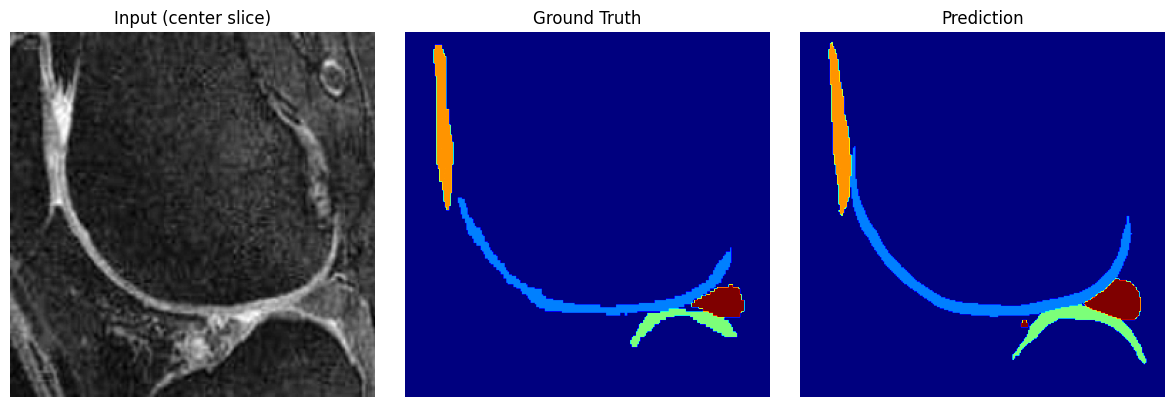

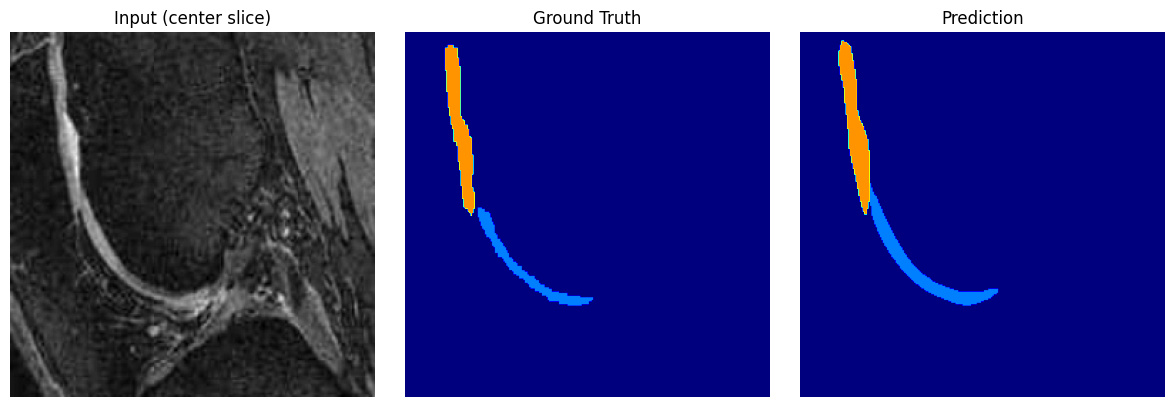

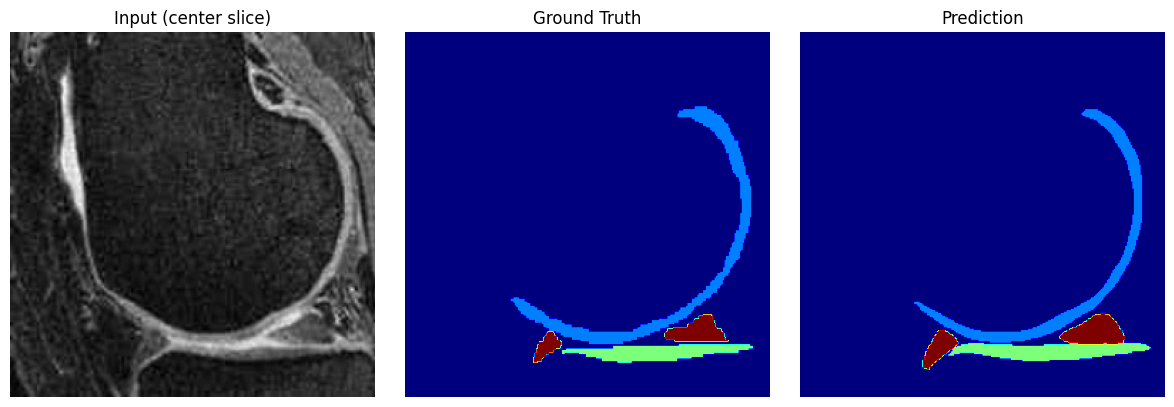

In [12]:
import matplotlib.pyplot as plt

# Load model
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

# 5 random samples from val_loader
samples = list(val_loader)
images, masks = samples[0]  # batch of 8 by default
images = images[:5].to(device)  # take first 5
masks = masks[:5].to(device)

with torch.no_grad():
    out = model(images)
    
    # Upsample logits to match target size
    logits_upsampled = F.interpolate(out.logits, size=[256,256], mode='bilinear', align_corners=False)
    preds = torch.argmax(logits_upsampled, dim=1)
    # preds = torch.argmax(preds, dim=1)  # [B, H, W]

# Plot
for i in range(5):
    img = images[i].cpu().numpy().transpose(1, 2, 0)  # [H, W, 3]
    true_mask = masks[i].cpu().numpy()
    pred_mask = preds[i].cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img[:, :, 1], cmap='gray')  # center slice of 2.5D stack
    axs[0].set_title("Input (center slice)")
    axs[1].imshow(true_mask, cmap='jet', vmin=0, vmax=4)
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask, cmap='jet', vmin=0, vmax=4)
    axs[2].set_title("Prediction")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

torch.Size([256, 256])



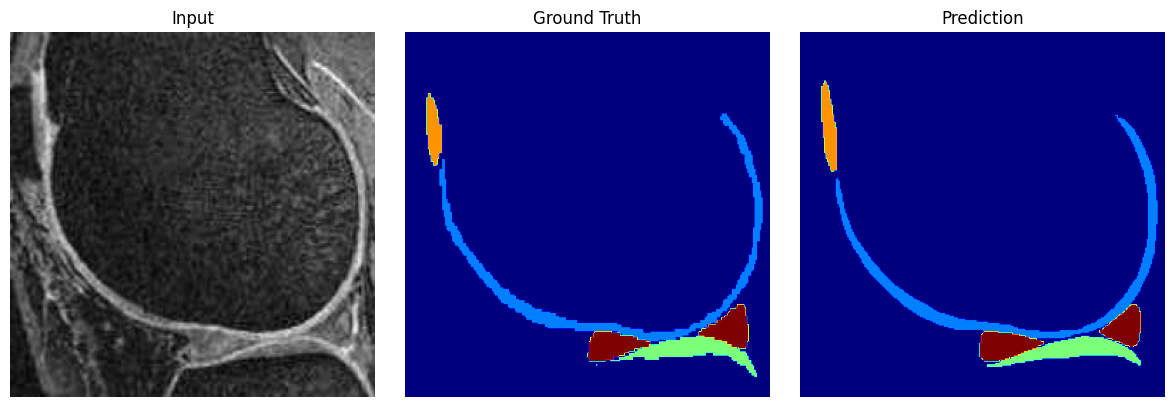

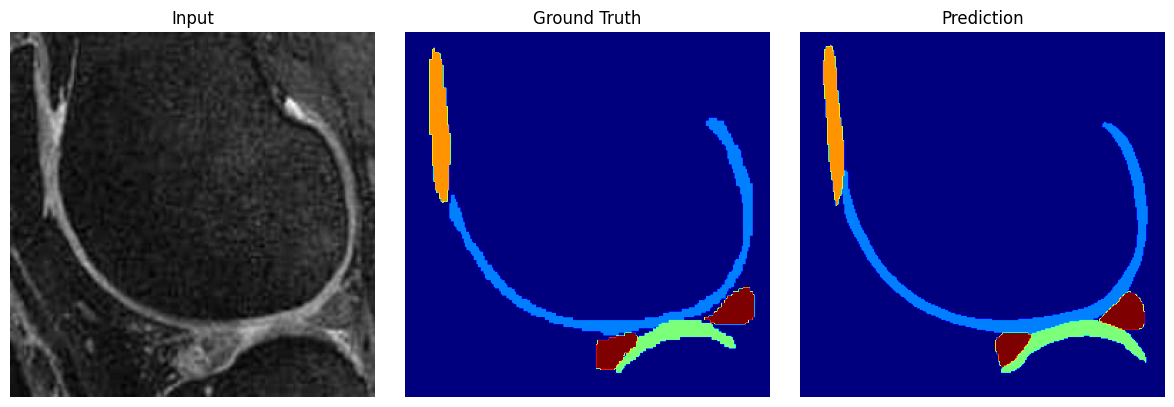

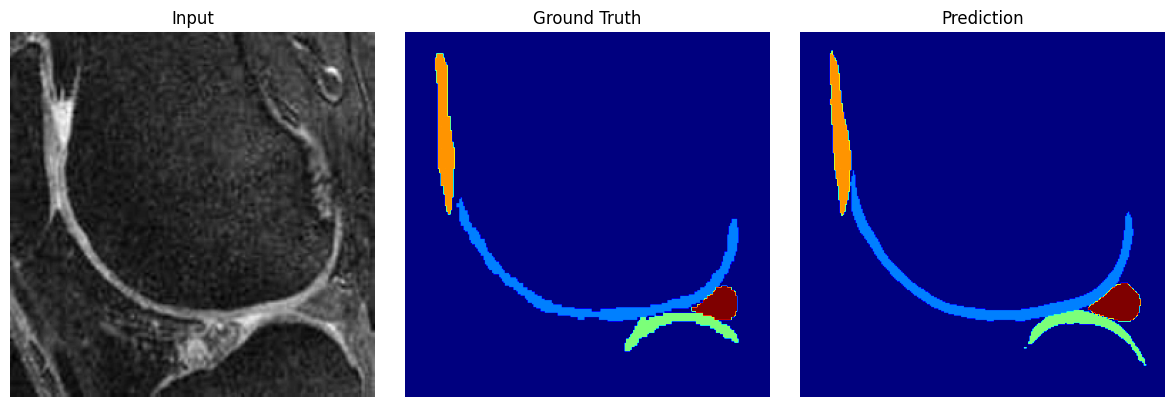

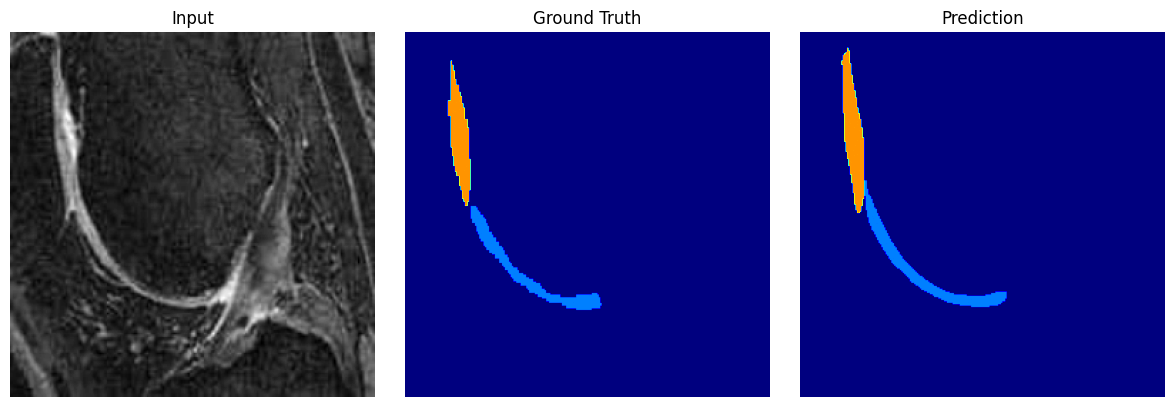

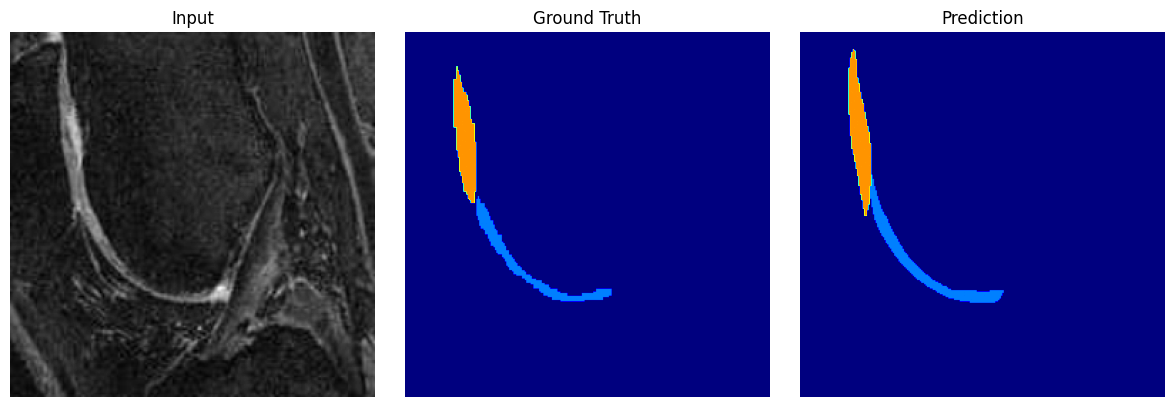

In [13]:
import matplotlib.pyplot as plt

# Load model
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

# 5 random samples from test_loader
samples = list(test_loader)
images, masks = samples[0]  # batch of 8 by default
print(images[0][0].shape)
print()
images = images[:5].to(device)  # take first 5
masks = masks[:5].to(device)

with torch.no_grad():
    out = model(images)

    # Upsample logits to match target size
    logits_upsampled = F.interpolate(out.logits, size=[256,256], mode='bilinear', align_corners=False)
    preds = torch.argmax(logits_upsampled, dim=1)
    # preds = torch.argmax(preds, dim=1)  # [B, H, W]

# Plot
for i in range(5):
    img = images[i].cpu().numpy().transpose(1, 2, 0)  # [H, W, 3]
    true_mask = masks[i].cpu().numpy()
    pred_mask = preds[i].cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img[:, :, 1], cmap='gray')  # center slice of 2.5D stack
    axs[0].set_title("Input")
    axs[1].imshow(true_mask, cmap='jet', vmin=0, vmax=4)
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask, cmap='jet', vmin=0, vmax=4)
    axs[2].set_title("Prediction")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [33]:
true_mask = masks[1].cpu().numpy()
num_ge_1 = np.sum(true_mask >= 1)
num_eq_0 = np.sum(true_mask == 0)

print(f"Pixels with value >= 1: {num_ge_1}")
print(f"Pixels with value == 0: {num_eq_0}")

Pixels with value >= 1: 2850
Pixels with value == 0: 144606
